
=== Acceptability table (per sentence × MF) ===
Function  Gaussian  Linear  Sigmoid  Trapezoidal
Sentence                                        
S1           0.895   0.933    0.986        1.000
S2           0.356   0.667    0.778        0.500
S3           0.926   0.967    0.990        1.000
S4           0.802   0.867    0.972        1.000
S5           0.675   0.833    0.942        0.833

=== Rank consistency (Spearman & Kendall) ===
        MF1          MF2  Spearman_rho  Kendall_tau
0  Gaussian       Linear         1.000        1.000
1  Gaussian      Sigmoid         1.000        1.000
2  Gaussian  Trapezoidal         0.894        0.837
3    Linear      Sigmoid         1.000        1.000
4    Linear  Trapezoidal         0.894        0.837
5   Sigmoid  Trapezoidal         0.894        0.837

=== Friedman test ===
chi^2 = 11.448980, p = 0.009530

=== Pairwise Wilcoxon (Holm-corrected) & Cliff's δ ===
       MF_A         MF_B  W_stat   p_raw  p_holm  rejected_0.05  \
0  Gaussian       L

C:\Users\AS.Viv\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\AS.Viv\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")



Saved files:
- acceptability_table.csv
- rank_consistency.csv
- wilcoxon_holm_cliffs.csv
- sensitivity_sigmoid.csv
- sensitivity_gaussian.csv
- sensitivity_sigmoid_k.png
- sensitivity_gaussian_sigma.png


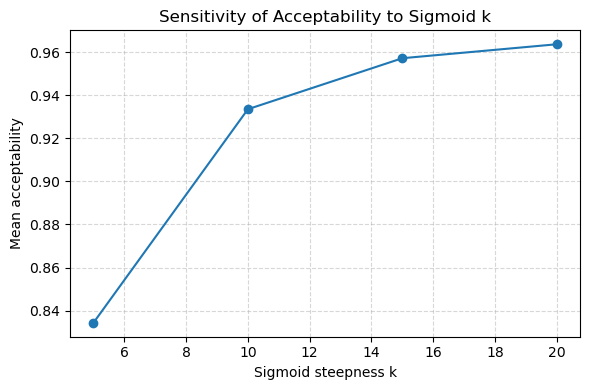

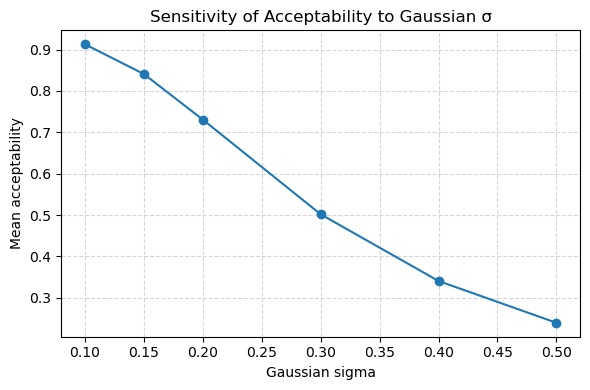

In [1]:
# -*- coding: utf-8 -*-
"""
Repro code for:
(2) Rank consistency (Spearman/Kendall)
(3) Statistical tests: Friedman + Holm-corrected Wilcoxon + Cliff's delta
(4) Sensitivity curves over k (Sigmoid) and sigma (Gaussian)

Run: python analysis_fuzzy_acceptability.py
"""

import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import spearmanr, kendalltau, friedmanchisquare, wilcoxon
from statsmodels.stats.multitest import multipletests

# -----------------------------
# 1) DATA & MEMBERSHIP FUNCTIONS (sesuai kode Bapak)
# -----------------------------
sentences = {
    "S1": "The cat sat on the mat.",
    "S2": "On the mat sat the cat?",
    "S3": "The dog chased the ball in the park.",
    "S4": "In the park, the ball was chased by the dog.",
    "S5": "Despite the rain, she managed to complete the run."
}

violation_scores = {
    "S1": [0.1, 0.0, 0.1],
    "S2": [0.3, 0.5, 0.2],
    "S3": [0.0, 0.1, 0.0],
    "S4": [0.1, 0.2, 0.1],
    "S5": [0.0, 0.2, 0.3],
}

def linear_mf(x):
    return x

def sigmoid_mf(x, alpha=10, center=0.5):
    return 1 / (1 + np.exp(-alpha * (x - center)))

def gaussian_mf(x, mean=0.5, sigma=0.2):
    return np.exp(-((x - mean)**2) / (2 * sigma**2))

def trapezoidal_mf(x, a=0.2, b=0.4, c=0.6, d=0.8):
    if x <= a:
        return 0.0
    elif a < x <= b:
        return (x - a) / (b - a)
    elif b < x <= c:
        return 1.0
    elif c < x <= d:
        return (d - x) / (d - c)
    else:
        return 0.0

MFs = {
    "Linear": lambda x: linear_mf(x),
    "Sigmoid": lambda x: sigmoid_mf(x, alpha=10, center=0.5),
    "Gaussian": lambda x: gaussian_mf(x, mean=0.5, sigma=0.2),
    "Trapezoidal": lambda x: trapezoidal_mf(x, a=0.2, b=0.4, c=0.6, d=0.8),
}

# -----------------------------
# 2) COMPUTE ACCEPTABILITY TABLE (per sentence × MF)
#    Acceptability = 1 - mean(mu_r) across 3 rules
# -----------------------------
rows = []
for sid, rules in violation_scores.items():
    for mf_name, mf in MFs.items():
        mus = [mf(score) for score in rules]
        acc = 1.0 - float(np.mean(mus))
        rows.append({"Sentence": sid, "Function": mf_name, "Acceptability": acc})

df = pd.DataFrame(rows)
pivot = df.pivot(index="Sentence", columns="Function", values="Acceptability").reindex(index=["S1","S2","S3","S4","S5"])
print("\n=== Acceptability table (per sentence × MF) ===")
print(pivot.round(3))

# Save CSV
pivot.round(6).to_csv("acceptability_table.csv", index=True)

# -----------------------------
# 3) RANK CONSISTENCY (Spearman & Kendall)
#    Rank per MF across the 5 sentences, then pairwise correlation
# -----------------------------
ranks = pivot.rank(ascending=False, method="average")  # higher acceptability = better rank
mf_names = list(ranks.columns)

rank_corr_records = []
for m1, m2 in itertools.combinations(mf_names, 2):
    rho, _ = spearmanr(ranks[m1], ranks[m2])
    tau, _ = kendalltau(ranks[m1], ranks[m2])
    rank_corr_records.append({"MF1": m1, "MF2": m2, "Spearman_rho": rho, "Kendall_tau": tau})

rank_corr_df = pd.DataFrame(rank_corr_records)
print("\n=== Rank consistency (Spearman & Kendall) ===")
print(rank_corr_df.round(3))
rank_corr_df.round(6).to_csv("rank_consistency.csv", index=False)

# -----------------------------
# 4) FRIEDMAN TEST + WILCOXON (Holm) + CLIFF'S DELTA
# -----------------------------
# Friedman requires repeated-measures: each row = a block (sentence), columns = treatments (MFs)
stat, pval = friedmanchisquare(*[pivot[col].values for col in pivot.columns])
print(f"\n=== Friedman test ===\nchi^2 = {stat:.6f}, p = {pval:.6f}")

# Pairwise Wilcoxon signed-rank between MFs (paired by sentence)
pairs = list(itertools.combinations(mf_names, 2))
wilcoxon_rows = []
pvals_raw = []

for a, b in pairs:
    # Using exact=False for small samples; change to exact=True if SciPy >=1.11 and applicable
    wstat, pw = wilcoxon(pivot[a], pivot[b], zero_method="wilcox", alternative="two-sided", correction=False, mode="auto")
    wilcoxon_rows.append({"MF_A": a, "MF_B": b, "W_stat": wstat, "p_raw": pw})
    pvals_raw.append(pw)

# Holm correction
rejected, pvals_holm, _, _ = multipletests(pvals_raw, alpha=0.05, method="holm")
for i, (a, b) in enumerate(pairs):
    wilcoxon_rows[i]["p_holm"] = pvals_holm[i]
    wilcoxon_rows[i]["rejected_0.05"] = bool(rejected[i])

# Cliff's delta helper
def cliffs_delta(x, y):
    """
    Cliff's delta for paired samples treated as unpaired effect size over paired differences.
    For N small, we can compute all pairwise comparisons x_i vs y_i (paired),
    but standard Cliff's delta is for two independent samples.
    Here we'll compute delta over paired differences sign.
    Alternatively, compute standard Cliff's delta on the two vectors as if independent.
    """
    # Standard definition (independent samples):
    xarr = np.array(x)
    yarr = np.array(y)
    n_x = len(xarr)
    n_y = len(yarr)
    greater = 0
    less = 0
    for xi in xarr:
        for yj in yarr:
            if xi > yj: greater += 1
            elif xi < yj: less += 1
    delta = (greater - less) / (n_x * n_y)
    return float(delta)

for i, (a, b) in enumerate(pairs):
    delta = cliffs_delta(pivot[a].values, pivot[b].values)
    wilcoxon_rows[i]["cliffs_delta_(A_vs_B)"] = delta

wilcoxon_df = pd.DataFrame(wilcoxon_rows)
print("\n=== Pairwise Wilcoxon (Holm-corrected) & Cliff's δ ===")
print(wilcoxon_df[["MF_A","MF_B","W_stat","p_raw","p_holm","rejected_0.05","cliffs_delta_(A_vs_B)"]].round(4))
wilcoxon_df.round(6).to_csv("wilcoxon_holm_cliffs.csv", index=False)

# -----------------------------
# 5) SENSITIVITY CURVES
# -----------------------------
def acceptability_with_sigmoid_k(k, center=0.5):
    def mf(x): return sigmoid_mf(x, alpha=k, center=center)
    vals = []
    for sid, rules in violation_scores.items():
        mus = [mf(v) for v in rules]
        vals.append(1.0 - float(np.mean(mus)))
    return np.mean(vals)

def acceptability_with_gaussian_sigma(sig, mean=0.5):
    def mf(x): return gaussian_mf(x, mean=mean, sigma=sig)
    vals = []
    for sid, rules in violation_scores.items():
        mus = [mf(v) for v in rules]
        vals.append(1.0 - float(np.mean(mus)))
    return np.mean(vals)

k_list = [5, 10, 15, 20]
sigma_list = [0.10, 0.15, 0.20, 0.30, 0.40, 0.50]

mean_acc_sigmoid = [acceptability_with_sigmoid_k(k) for k in k_list]
mean_acc_gauss   = [acceptability_with_gaussian_sigma(s) for s in sigma_list]

sens_df = pd.DataFrame({
    "k": k_list,
    "mean_acceptability_sigmoid": mean_acc_sigmoid
})
sens_df2 = pd.DataFrame({
    "sigma": sigma_list,
    "mean_acceptability_gaussian": mean_acc_gauss
})
sens_df.to_csv("sensitivity_sigmoid.csv", index=False)
sens_df2.to_csv("sensitivity_gaussian.csv", index=False)

print("\n=== Sensitivity (Sigmoid k) ===")
print(sens_df.round(6))
print("\n=== Sensitivity (Gaussian sigma) ===")
print(sens_df2.round(6))

# Plot sensitivity curves
plt.figure(figsize=(6,4))
plt.plot(k_list, mean_acc_sigmoid, marker='o')
plt.xlabel("Sigmoid steepness alpha")
plt.ylabel("Mean acceptability")
plt.title("Sensitivity of Acceptability to Sigmoid alpha")
plt.grid(True, axis='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("sensitivity_sigmoid_k.png", dpi=300)
# plt.show()

plt.figure(figsize=(6,4))
plt.plot(sigma_list, mean_acc_gauss, marker='o')
plt.xlabel("Gaussian sigma")
plt.ylabel("Mean acceptability")
plt.title("Sensitivity of Acceptability to Gaussian σ")
plt.grid(True, axis='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("sensitivity_gaussian_sigma.png", dpi=300)
# plt.show()

print("\nSaved files:")
print("- acceptability_table.csv")
print("- rank_consistency.csv")
print("- wilcoxon_holm_cliffs.csv")
print("- sensitivity_sigmoid.csv")
print("- sensitivity_gaussian.csv")
print("- sensitivity_sigmoid_k.png")
print("- sensitivity_gaussian_sigma.png")
